## Create Snow-On DEM with JSON Pipeline using PDAL

## Import Libraries

In [3]:
import numpy as np
import pdal
import json
import laspy
import open3d as o3d
import os
import matplotlib.pyplot as plt
import rioxarray as rxa
from os.path import join, basename, exists, dirname, abspath
from glob import glob
import geopandas as gpd
import fiona
from zipfile import ZipFile
import shlex
import subprocess
import py3dep
from shapely.geometry import box
import pyproj
from shapely.geometry import Point
from shapely.ops import transform
import contextily as cx

## Define Functions
Right now we only have one to do command line calls. Probably can be put into a seperate functions script and imported if we want to clean this up.

In [4]:
def cl_call(commamd):
    process = subprocess.Popen(commamd, 
                           stdout=subprocess.PIPE,
                           universal_newlines=True)

    while True:
        output = process.stdout.readline()
        print(output.strip())
        # Do something else
        return_code = process.poll()
        if return_code is not None:
            print('RETURN CODE', return_code)
            # Process has finished, read rest of the output 
            for output in process.stdout.readlines():
                print(output.strip())
            break

## Capture filepaths for .laz and .kmz

test_dir = directory name. We can iterate over this variable in future full runs to do all the lidar processing with one function

In [5]:
test_dir = abspath('../test/09_EXPORT')
laz_fps = glob(join(test_dir,'*.laz'))[:2]
kmz_fp = glob(join(test_dir,'*.kmz'))[0]

## Extract and visualize helicopter flight path (not neccessary for lidar processing)

In [ ]:
with ZipFile(kmz_fp, 'r') as kmz:
    kml_fps = kmz.namelist()
    kmz.extractall(test_dir)
kml_fp = [fp for fp in kml_fps if fp.endswith('kml')][0]
my_map = gpd.read_file(join(test_dir, kml_fp), driver='KML')
my_map[::1000].explore()

## Mosaicing all LAZ files to one
Tried Las2las - really didn't work. Pdal merge seems to be working (based on file size alone)

In [13]:
# in_fps_str = f'{laz_fps}'.replace('[','').replace(']','')
in_str = join(test_dir, '*.laz')
out_fp = join(test_dir, 'merge.laz')
mosaic_cmd = f'pdal merge {in_str} {out_fp}'
mosaic_cmd = shlex.split(mosaic_cmd)
print(mosaic_cmd)
#  cl_call(mosaic_cmd)

['pdal', 'merge', '/Users/zachkeskinen/Documents/ice-road-copters/test/09_EXPORT/*.laz', '/Users/zachkeskinen/Documents/ice-road-copters/test/09_EXPORT/merge.laz']


## Download DEM for dem filtering step

Needs to be projected into the right CRS (got from las files)

In [27]:
import laspy
filepath = out_fp

with laspy.open(filepath) as data:
     hdr = data.header
     crs = hdr.parse_crs()
wgs84 = pyproj.CRS('EPSG:4326')
utm_bounds = box(hdr.mins[0], hdr.mins[1], hdr.maxs[0], hdr.maxs[1])
project = pyproj.Transformer.from_crs(crs, wgs84 , always_xy=True).transform
wgs84_bounds = transform(project, utm_bounds)
dem_wgs = py3dep.get_map('DEM', wgs84_bounds, resolution = 1, crs = 'epsg:4326')
dem_utm = dem_wgs.rio.reproject(crs)
dem_fp = join('/Users/zachkeskinen/Documents/ice-road-copters/test/dems','full.tif')
dem_utm.rio.to_raster(dem_fp)
print(crs)
print(crs.ellipsoid)

epsg:32611
WGS 84


## Building JSON Pipeline from standard JSON pipeline

TO BE DONE!
Should only need to change the input file name to the mosaic outcome. 

Alternative:
use the:
- --readers.las.filename=str(out_fp)
- --writers.las.filename=str(join(test_dir, 'out.laz'))
- --writers.gdal.filename=str(join(test_dir, 'out.tif'))

## Running JSON Pipeline

In [29]:
pipeline_cmd = f'pdal pipeline -i ./jsons/test.json --readers.las.filename="{out_fp}"'
# pipeline_cmd = 'pdal pipeline -i test.json -v 8'
pipeline_cmd = shlex.split(pipeline_cmd)
print(pipeline_cmd)
cl_call(pipeline_cmd)

['pdal', 'pipeline', '-i', './jsons/test.json', '--readers.las.filename=/Users/zachkeskinen/Documents/ice-road-copters/test/09_EXPORT/merge.laz']


### Playing with Tiling in PDAL

In [ ]:
# out_fns = join(test_dir, 'tiled', basename(laz_fps[0]).replace('.laz','') + '-#.laz')
# cmd = shlex.split(f'pdal tile -i {laz_fps[0]} -o {out_fns} --length 1000 -v 8')

# os.makedirs(join(test_dir, 'tiled'), exist_ok= True)
# cl_call(cmd)
# tiled_fps = glob(join(test_dir, 'tiled', '*.laz'))

## Visualization

o3d visualization is awesome but seems to kill my kernel everytime when I try and close the window. 

Rioxarray visualization seems safer for quick checks

In [ ]:
PC = laspy.read('/Users/zachkeskinen/Documents/ice-road-copters/test/09_EXPORT/crop.laz')

points = np.vstack((PC.X, PC.Y, PC.Z)).transpose()

cloud = o3d.geometry.PointCloud()
cloud.points = o3d.utility.Vector3dVector(points)
#pcd.colors = o3d.utility.Vector3dVector(colors/65535)
#pcd.normals = o3d.utility.Vector3dVector(normals)0
o3d.visualization.draw_geometries([cloud])

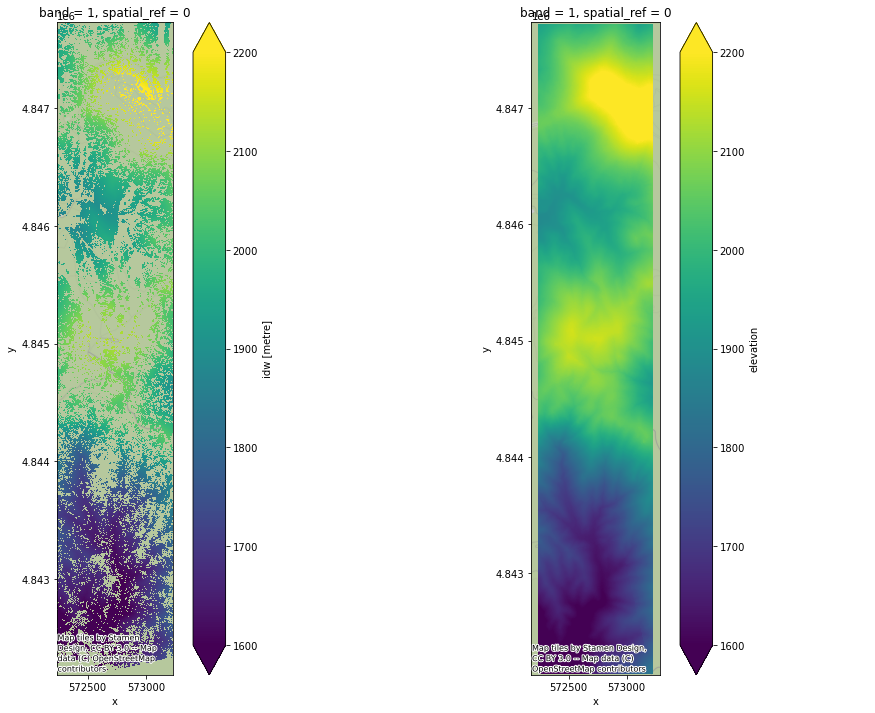

In [25]:
out = rxa.open_rasterio('/Users/zachkeskinen/Documents/ice-road-copters/test/09_EXPORT/merged_out.tif', mask_and_scale=True)
f, (ax, ax2) = plt.subplots(1, 2, figsize = (16,12))
out.plot(ax = ax, vmin = 1600, vmax = 2200)
dem = rxa.open_rasterio('/Users/zachkeskinen/Documents/ice-road-copters/test/dems/full.tif', mask_and_scale=True)
dem.plot(ax = ax2, vmin = 1600, vmax = 2200)
cx.add_basemap(ax= ax, crs = crs)
cx.add_basemap(ax = ax2, crs = crs)

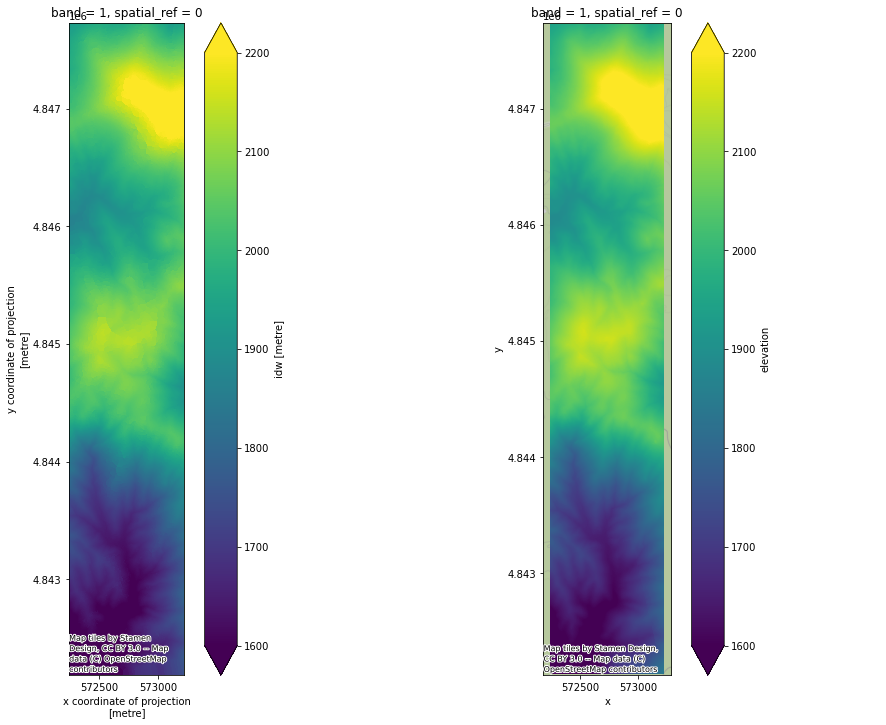

In [26]:
f, (ax, ax2) = plt.subplots(1, 2, figsize = (16,12))
filled = out.rio.interpolate_na()
filled.plot(ax = ax, vmin = 1600, vmax = 2200)
dem.plot(ax = ax2, vmin = 1600, vmax = 2200)
cx.add_basemap(ax= ax, crs = crs)
cx.add_basemap(ax = ax2, crs = crs)